In [36]:
# %load_ext autoreload
# %autoreload 2

In [37]:
import csv
import joblib

from pathlib import Path
from rdkit.Chem import AllChem
from rdkit.Chem.PandasTools import RenderImagesInAllDataFrames

import gloryxr
from gloryxr.should_be_in_fame3r import Fame3RVectorizer

RenderImagesInAllDataFrames(images=True)

In [38]:
vectorizer = Fame3RVectorizer().fit()

In [39]:
models = {
    path.name.removesuffix(".joblib"): joblib.load(path)
    for path in Path("models").glob("*.joblib")
}

In [40]:
reaction_subsets = {
    row["Reaction name"]: row["Name of rule subset"]
    for row in csv.DictReader(open("./gloryxr/rules_data/gloryx_reactionrules.csv"))
}

In [41]:
concrete_reactions = gloryxr.utils.reactions_to_table(
    gloryxr.Reactor(strict_soms=True).react_one(AllChem.MolFromSmiles("c1ccccc1NC"))
).pipe(
    lambda df: df.assign(
        Subset=df.Reaction.map(lambda name: reaction_subsets[name]),
    )
)

[14:07:06] WARNING: Proton(s) added/removed

[14:07:06] WARNING: Proton(s) added/removed

[14:07:06] WARNING: Proton(s) added/removed

[14:07:06] WARNING: Omitted undefined stereo



In [42]:
predictions = (
    concrete_reactions.pipe(
        lambda df: df.assign(SOM=df.Educt.map(gloryxr.utils.extract_similes_for_soms))
    )
    .explode("SOM")
    .pipe(lambda df: df.assign(Descriptors=df.SOM.map(vectorizer.transform_one)))
    .pipe(
        lambda df: df.assign(
            Score=df.apply(
                lambda row: models[row.Subset].predict_proba([row.Descriptors])[0, -1],
                axis=1,
            )
        )
    )
)

,Educt,Reaction,Product,Descriptors,Score
ID,,,,,
0,,N-demethylation_(R-NHCH3),,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.77
1,,N-demethylation_(c-NHCH3),,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.77
2,,aromatic_hydroxylation_(para_to_nitrogen),,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.68
3,,aromatic_hydroxylation_(ortho_to_nitrogen),,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.04
4,,aliphatic hydroxylation,,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.68
5,,aromatic hydroxylation,,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.04
6,,aromatic hydroxylation,,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.04
7,,aromatic hydroxylation,,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.68
8,,amine hydroxylation,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.77

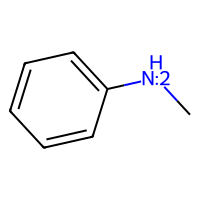
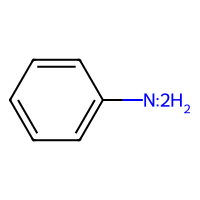
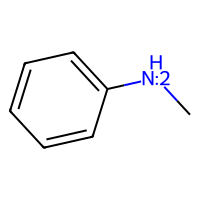
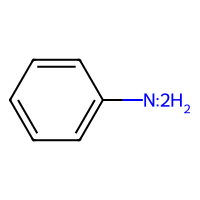
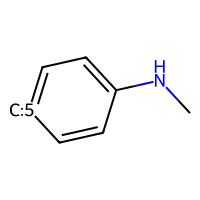
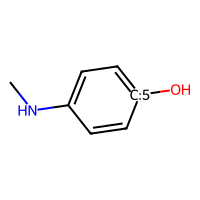
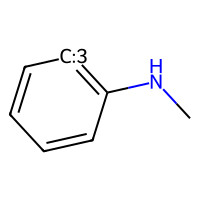
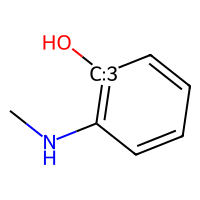
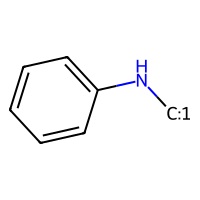
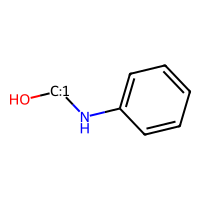
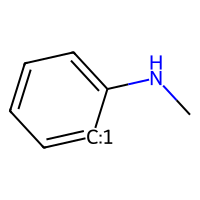
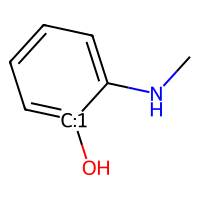
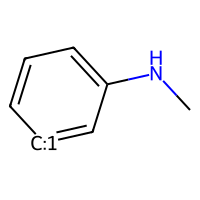
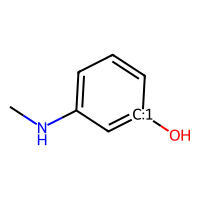
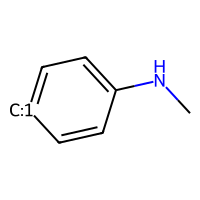
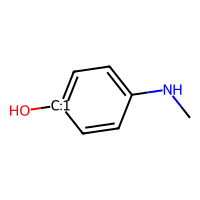
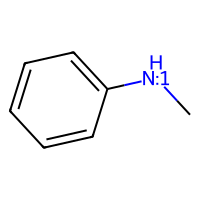
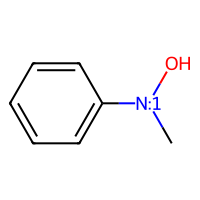
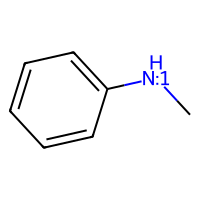
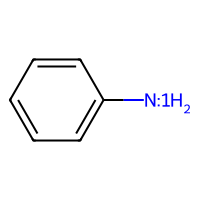
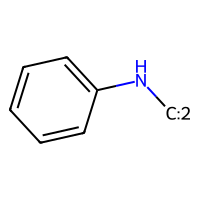
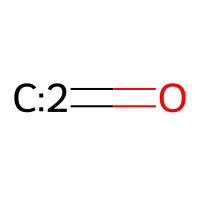
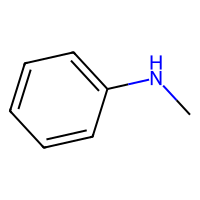
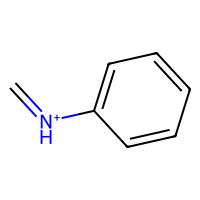
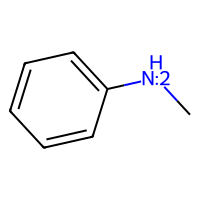
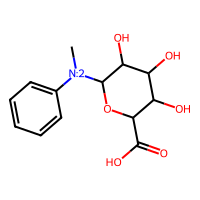

In [43]:
predictions[["Educt", "Reaction", "Product", "Descriptors", "Score"]]

# Results from the predict_metabolites.py pipeline

In [47]:
import pandas as pd
from ipywidgets import interact, IntSlider
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles

In [49]:
results = pd.read_csv("/Users/roxanejacob/Desktop/GLORYxr/GLORYx_data/test/results/metabolite_predictions.csv")

In [50]:
@interact(i = IntSlider(min=0, max=len(results), step=1))
def f(i):
    row = results.iloc[i]
    parent_smiles = row.parent_smiles
    metabolite_smiles = row.metabolite_smiles
    reaction = row.reaction
    rule_subset = row.rule_subset
    som = row.som
    score = row.score

    parent_mol = MolFromSmiles(parent_smiles)
    metabolite_mol = MolFromSmiles(metabolite_smiles)

    print(reaction, rule_subset, score)

    drawing = Draw.MolsToGridImage(
        mols=[parent_mol, metabolite_mol],
        subImgSize=(400, 400),
    )

    display(drawing)


interactive(children=(IntSlider(value=0, description='i', max=4563), Output()), _dom_classes=('widget-interact…